<a href="https://colab.research.google.com/github/daniruro19/Python/blob/main/ruizDaniel_churnKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Preparación de los datos

In [ ]:
df = pd.read_csv('churn.csv')
print(len(df))
df.head().T

In [ ]:
df.dtypes

In [ ]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)
df[total_charges.isnull()][['customerID', 'TotalCharges']]

In [ ]:
replacer = lambda str: str.lower().str.replace(' ', '_')
df.columns = replacer(df.columns.str)
for col in list(df.dtypes[df.dtypes == 'object'].index):
    df[col] = replacer(df[col].str)
df.head().T

In [ ]:
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

In [ ]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
                'phoneservice', 'multiplelines', 'internetservice',
                'onlinesecurity', 'onlinebackup', 'deviceprotection',
                'techsupport', 'streamingtv', 'streamingmovies',
                'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']
df[categorical].nunique()

In [ ]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

df_train.head().T

# Análisis de la importancia de las propiedades

In [ ]:
global_mean = df_train_full.churn.mean()
round(global_mean, 3)

0.27

In [ ]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print(round(female_mean, 3))
male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print(round(male_mean, 3))

0.277
0.263


In [ ]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print(round(partner_yes, 3))
partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print(round(partner_no, 3))

0.205
0.33


In [ ]:
from sklearn.metrics import mutual_info_score

calculate_mi = lambda col: mutual_info_score(col, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

In [ ]:
print(df_train_full[numerical].corrwith(df_train_full.churn))

print(round(df_train_full[df_train_full.tenure <= 2].churn.mean(), 3))
print(round(df_train_full[(df_train_full.tenure > 3) & 
                          (df_train_full.tenure <= 12)].churn.mean(), 3))
print(round(df_train_full[df_train_full.tenure > 12].churn.mean(), 3))

print(round(df_train_full[df_train_full.monthlycharges < 20].churn.mean(), 3))
print(round(df_train_full[(df_train_full.monthlycharges > 21) & 
                          (df_train_full.monthlycharges <= 50)].churn.mean(), 3))
print(round(df_train_full[df_train_full.monthlycharges > 50].churn.mean(), 3))

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64
0.595
0.391
0.176
0.088
0.223
0.325


# Ingeniería de propiedades

In [ ]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dict(sorted(train_dict[0].items()))

In [ ]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [ ]:
X_train = dv.transform(train_dict)
X_train[0]

array([  1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         0.  ,   1.  ,   0.  ,   1.  ,   0.  ,  85.55,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         1.  ,   1.  ,   0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   5.  , 408.5 ])

In [ ]:
dv.get_feature_names_out()

# Entrenamiento del modelo

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
y_pred

array([[0.99142714, 0.00857286],
       [0.79028712, 0.20971288],
       [0.78364454, 0.21635546],
       ...,
       [0.35664296, 0.64335704],
       [0.81055916, 0.18944084],
       [0.87261929, 0.12738071]])

In [ ]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.00857286, 0.20971288, 0.21635546, ..., 0.64335704, 0.18944084,
       0.12738071])

In [ ]:
churn = y_pred >= 0.5
churn

array([False, False, False, ...,  True, False, False])

In [ ]:
# precisión del modelo con los datos de entrenamiento
round((y_val == churn).mean(), 3) 

0.805

# Modelo

In [ ]:
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
y_pred

array([[0.99142714, 0.00857286],
       [0.79028712, 0.20971288],
       [0.78364454, 0.21635546],
       ...,
       [0.35664296, 0.64335704],
       [0.81055916, 0.18944084],
       [0.87261929, 0.12738071]])

#MODELO CON KERAS Y TENSOR FLOW

In [102]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [103]:
dataset = pd.read_csv('churn.csv')
dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [142]:
model = Sequential()
model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 12)                552       
                                                                 
 dense_31 (Dense)            (None, 8)                 104       
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________


In [145]:
from keras.optimizers import Adam
# compile the keras model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=int(len(df)/3))

In [56]:
loss,accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

118/118 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.7999
Accuracy: 79.99


In [57]:
model.history

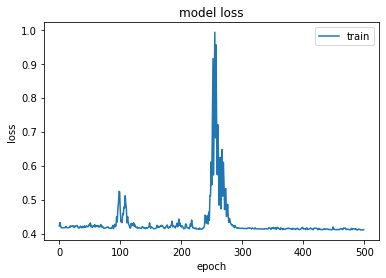

In [116]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper right")
plt.show()


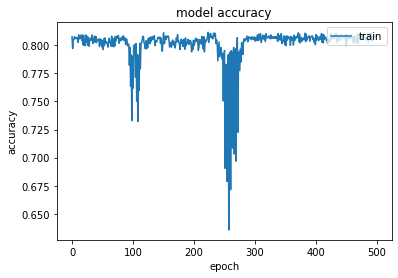

In [117]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper right")
plt.show()


In [83]:
dataset1 = pd.read_csv('churn.csv')
dataset1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [132]:
y2= pd.DataFrame(y_train,columns=["churn"])
target_dummies = pd.get_dummies(y2['churn'])

In [149]:
model = Sequential()
model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 12)                552       
                                                                 
 dense_34 (Dense)            (None, 8)                 104       
                                                                 
 dense_35 (Dense)            (None, 2)                 18        
                                                                 
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


In [150]:
from keras.optimizers import Adam
# compile the keras model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,target_dummies, epochs=500, batch_size=int(len(df)/3))

In [152]:
loss,accuracy = model.evaluate(X_train,target_dummies)
print('Accuracy: %.2f' % (accuracy*100))

118/118 [==============================] - 1s 3ms/step - loss: 1.6361 - accuracy: 0.7798
Accuracy: 77.98


In [153]:
model.history

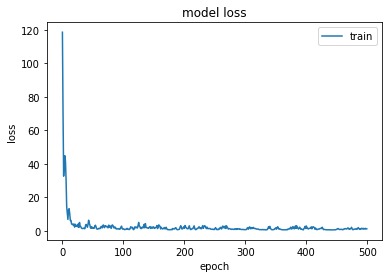

In [154]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper right")
plt.show()

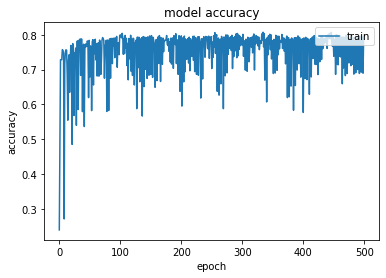

In [155]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper right")
plt.show()